### Section 1: Importing Libraries ###

In [1]:
import pandas as pd
import numpy as np
import sys, os
from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


### Section 2 - Importing data - Coordinates Dataset ###

In [2]:
#Load the first X lines - law of large numbers good enough approximation of the dataset. 

path = "D:\Itinerum Data\MTLTrajet2018\MTLTrajet2018\coordinates.csv"
num_rows = 500000

data_path = path

raw = pd.read_csv(data_path, nrows=num_rows) 


### Section 3 - Cleaning the data - Dropping useless columns ###

In [3]:
# Dropping useless columns #

columns_todrop = ['altitude','direction','mode_detected','point_type','h_accuracy','v_accuracy','acceleration_x','acceleration_y','acceleration_z']

raw.drop(columns_todrop,axis=1,inplace=True)

# Confirming columns that were dropped are dropped #

raw.dtypes

uuid              object
latitude         float64
longitude        float64
speed            float64
timestamp_UTC     object
dtype: object

### Renaming Speed Column to Instantaneous Speed ###

In [4]:
raw.rename(columns={"speed":'instantaneous_speed'},inplace=True)

### Processing timestamp columns into datetime object type ###

In [5]:
def convert(time):
    return datetime.strptime(time, '%Y-%m-%dT%H:%M:%S')

temp = raw.timestamp_UTC.apply(convert)

raw.drop(['timestamp_UTC'],axis=1,inplace=True)

raw['timestamp_UTC'] = temp

raw.dtypes

uuid                           object
latitude                      float64
longitude                     float64
instantaneous_speed           float64
timestamp_UTC          datetime64[ns]
dtype: object

### Sorting the data by Unique User ID and timestamp ###

In [6]:
columns_tosort = ['uuid','timestamp_UTC']
raw = raw.sort_values(columns_tosort) 

raw.head()

,uuid,latitude,longitude,instantaneous_speed,timestamp_UTC
4505,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.513693,-73.572468,0.821313,2018-09-24 12:48:15
17894,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.515821,-73.570871,1.635770,2018-09-24 17:08:41
17932,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.516021,-73.570669,1.403768,2018-09-24 17:09:01
17978,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.516222,-73.570820,0.911125,2018-09-24 17:09:28
18008,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.516353,-73.571106,1.105285,2018-09-24 17:09:43


### Resetting the index to follow sequential order ###

In [7]:
raw.reset_index(drop=True,inplace=True)
raw.head()

,uuid,latitude,longitude,instantaneous_speed,timestamp_UTC
0,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.513693,-73.572468,0.821313,2018-09-24 12:48:15
1,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.515821,-73.570871,1.635770,2018-09-24 17:08:41
2,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.516021,-73.570669,1.403768,2018-09-24 17:09:01
3,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.516222,-73.570820,0.911125,2018-09-24 17:09:28
4,003502B3-82CE-46C3-96E1-68F92A14C9D5,45.516353,-73.571106,1.105285,2018-09-24 17:09:43


### Value Counts for the unique User IDs ###

In [8]:
uuid_sortedfrequency = (raw.uuid.value_counts()).index.tolist() # List of UUIDs sorted in descending order by frequency

frequency_threshold = 4 

uuid_sortedfrequency = raw.uuid.value_counts()[raw.uuid.value_counts()>frequency_threshold].index.tolist()


#### Section 4: Feature Engineering ###

In [9]:
raw = (raw[raw.instantaneous_speed < 40]) # Sorting the speeds to ensure less than 140 km/hour. 

In [10]:
raw['time_difference'] = raw.timestamp_UTC.diff().dt.seconds + 1   #Time difference is in seconds

In [11]:
raw['insta_speed_difference'] = raw.instantaneous_speed.diff() # This will subtract the speed in postiion 2 - position 1

In [12]:
raw['instantaneous_acceleration'] = raw.insta_speed_difference / raw.time_difference  # divide the speed difference with the time difference to get the acceleration 

In [13]:
raw['insta_acceleration_difference'] = raw.instantaneous_acceleration.diff()   # This will subtract the acceleration in position 2 - position 1 

In [14]:
raw['instantaneous_jerk'] = raw.insta_acceleration_difference / raw.time_difference  # Jerk (4th derivative of Transportation)  

In [15]:
coordinates =  list(zip(raw.latitude, raw.longitude))
raw['LatLon'] = coordinates 

In [16]:
# Identifying the time of the day #

def hours(x):
    if x>=6 and x<=9:
        return 'MR'             # Morning Rush
    elif x>=15 and x<=18:
        return 'NR'             #Night rush
    else:
        return 'S' #Stationary
    
raw['RushhourType'] = raw.timestamp_UTC.dt.hour.apply(hours)  

In [17]:
# Identifying when public transit is closed or open #

def closed_transit(x):
    if x >=1 and x<=5:
        return 1        # Closed Transit
    else:
        return 0        # Open Transit

raw['ClosedTransit'] = raw.timestamp_UTC.dt.hour.apply(closed_transit)

### Defining the Bearing (Direction) Function ###

In [18]:
import math 
def Bearing(lat1,lon1,lat2,lon2):
    dLon = lon2 - lon1;
    y = math.sin(dLon) * math.cos(lat2);
    x = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dLon)
    brng = np.degrees(math.atan2(y, x))
    if brng < 0:
        brng+= 360
    return brng  

### Adding the Distance between points and Direction between points Features ###

In [19]:
direction = [np.nan]
vals = [np.nan]
LL_col = pd.DataFrame()
LL_col['LL'] = raw.LatLon.as_matrix()

for i in range(1, raw.shape[0]):
    
    pair1 = LL_col['LL'][i-1]
    pair2 = LL_col['LL'][i]
    val = (haversine(pair1,pair2,unit='m'))
    vals.append(val)
    direction_value = Bearing(pair1[0],pair1[1],pair2[0],pair2[1])
    direction.append(direction_value)
    
raw['Distance'] = vals
raw['Direction'] = direction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [20]:
raw['Average Velocity'] = raw.Distance/raw.time_difference  # Average Velocity Feature #

In [21]:
raw['Average Acceleration'] = raw['Average Velocity'] / raw.time_difference  # Average Accelration Feature #

In [22]:
# Determining if point is on a weekday or weekend #

raw['Weekends'] = raw.timestamp_UTC.dt.day_name()
raw.Weekends = raw.Weekends.replace(to_replace=['Saturday','Sunday'], value=1) # Weekends denoted with value of 1. 
raw.Weekends = raw.Weekends.replace(to_replace=['Monday','Tuesday','Wednesday','Thursday','Friday'], value=0) # Weekdays denoted with a value of 0. 

In [23]:
# Determing what time of the day coordinate is in #

def time_of_day(x):
    if x>= 5 and x<10:
        return 'morning'
    elif x>=10 and x<12:
        return 'lunch'
    elif x>=12 and x<16:
        return 'afternoon'
    elif x>=16 and x<18:
        return 'evening'
    elif ((x>=18 and x<=24) or (x>24 and x<5)):
        return 'night'
    else:
        return np.nan

raw['TimeOfDay'] = raw.timestamp_UTC.dt.hour.apply(time_of_day)

In [24]:
# Convert Latitude and Longitude into x,y,z coordinates # 

x_coordinate = []
y_coordinate = []
z_coordinate = []

R = 6371000 # radius of earth in meters 

import math 
for i in range(len(raw)):
   
    x = R * math.cos(raw.latitude.iloc[i]) * math.cos(raw.longitude.iloc[i])

    y = R * math.cos(raw.latitude.iloc[i]) * math.sin(raw.longitude.iloc[i])

    z = R * math.sin(raw.latitude.iloc[i])

       
    x_coordinate.append(x)
    y_coordinate.append(y)
    z_coordinate.append(z)

raw['x_coordinate'] = x_coordinate
raw['y_coordinate'] = y_coordinate
raw['z_coordinate'] = z_coordinate


### Fill NaNs with 0's. ###

In [25]:
fill_nans = 0
raw.fillna(fill_nans,inplace=True)

### Section 5: Determining Segment Stops to classify Trip Time Series ### 

### Part 1: Identifying stops based on prompt_csv dataset ###

In [26]:
# sample of 1 unique user ID - TEMP_DF is the new dataframe moving forward #

# Select most frequent UUID
user_uuid = uuid_sortedfrequency[0]

# Manual UUID Selection: 
#user_uuid = '003502B3-82CE-46C3-96E1-68F92A14C9D5'

temp_df = raw[raw['uuid'] == user_uuid]

# Copy of original dataframe # 
eval_df = temp_df



In [27]:
temp_df.columns

Index(['uuid', 'latitude', 'longitude', 'instantaneous_speed', 'timestamp_UTC',
       'time_difference', 'insta_speed_difference',
       'instantaneous_acceleration', 'insta_acceleration_difference',
       'instantaneous_jerk', 'LatLon', 'RushhourType', 'ClosedTransit',
       'Distance', 'Direction', 'Average Velocity', 'Average Acceleration',
       'Weekends', 'TimeOfDay', 'x_coordinate', 'y_coordinate',
       'z_coordinate'],
      dtype='object')

In [28]:
prompt_datapath = 'D:\Itinerum Data\MTLTrajet2018\MTLTrajet2018\prompt_responses.csv'

prompt = pd.read_csv(prompt_datapath) 

prompt.rename({'user_uuid':'uuid'},axis=1,inplace=True)

In [29]:
cols_todrop = ['prompt_uuid', 'mode', 'mode_id', 'purpose', 'purpose_id','displayed_at_epoch', 'recorded_at_UTC','recorded_at_epoch', 'latitude', 'longitude']

prompt.drop(cols_todrop,axis=1,inplace=True)

In [30]:
def convert(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

temp = prompt.displayed_at_UTC.apply(convert)

In [31]:
lbound_timestamp = temp-timedelta(seconds=5)

rbound_timestamp = temp+timedelta(seconds=5)

prompt['lb_timestamp'] = lbound_timestamp
prompt['rb_timestamp'] = rbound_timestamp
prompt['timestamp_UTC'] = temp

In [32]:
#prompt.drop(['displayed_at_UTC'],axis=1,inplace=True)
prompt.dtypes

uuid                        object
displayed_at_UTC            object
lb_timestamp        datetime64[ns]
rb_timestamp        datetime64[ns]
timestamp_UTC       datetime64[ns]
dtype: object

In [33]:
# Selecting data for 1 day from prompt dataset #
start = temp_df.head(1).timestamp_UTC 
start_time = pd.to_datetime(start.values[0]).date()
end = temp_df.tail(1).timestamp_UTC
end_time = pd.to_datetime(end.values[0]).date()
end_time = end_time +timedelta(days=1)

In [34]:
prompt = prompt[prompt.timestamp_UTC <= end_time]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [35]:
times = list(zip(prompt.lb_timestamp,prompt.rb_timestamp))

stops = []

for i in range(len(times)):
    val = temp_df.loc[temp_df.loc[:, 'timestamp_UTC'].between(times[i][0],times[i][1]), : ]
    stops.append(val)

clean_time = []

for val in stops:
    if val.empty:
        continue
    elif not val.empty:
        clean_time.append(val)

In [36]:
indexes = []
for x in clean_time:
    indexes.append(x.index)

index_ = []
for x in indexes:
    index_.append((x.values))

index_values = []
for i in range(len(index_)):
    val = index_[i][0]
    index_values.append(val)

In [37]:
flag = []

for x in temp_df.index.values:
    if x in index_values:
        flag.append(1)
    else:
        flag.append(0)


In [38]:
temp_df['Application_stop'] = flag

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Part 2: Signal Loss Stops ###

In [39]:
signal_loss = []

threshold_loss = np.percentile(temp_df.time_difference,97.5)

for val in temp_df.time_difference:
    if val > threshold_loss:
        signal_loss.append(1)
    elif val <= threshold_loss:
        signal_loss.append(0)



In [40]:
threshold_loss

117.0

In [41]:
temp_df['signal_loss'] = signal_loss

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
speed_threshold = 0.5      # Units: m/s

temp_df['User_stopped'] = (temp_df['Average Velocity'] < speed_threshold).astype(int) # True is 1, False is 0. 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
signal_loss_stops = []

for x in temp_df.index.values:
    if x in temp_df[(temp_df.signal_loss == 1) & (temp_df.User_stopped == 1)].index.values:
        signal_loss_stops.append(1)
    else:
        signal_loss_stops.append(0)

for i in range(len(signal_loss_stops)):
    if signal_loss_stops[i] == 1:
        signal_loss_stops[(i-1)] = 1
        signal_loss_stops[i] = 0
        
temp_df['signal_loss_stops'] = signal_loss_stops

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
# Can omit this cell - if would like to keep these columns # 

temp_df.drop(['signal_loss','User_stopped'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Part 3 - Stops at Home, Work, Study Proximity ###

In [45]:
survey_path = "D:\Itinerum Data\MTLTrajet2018\MTLTrajet2018\survey_responses.csv"
survey_df = pd.read_csv(survey_path)

In [46]:
user_uuid = uuid_sortedfrequency[0]  # pass in the UUID of choice here. #Manual -> user_uuid = '003502B3-82CE-46C3-96E1-68F92A14C9D5'

survey_df = survey_df[survey_df['uuid'] == user_uuid]

survey_df.drop(['age_bracket_id', 'gender_id', 'member_type_id', 'document_id',
       'num_of_people', 'num_of_cars', 'num_of_minors', 'email', 'model',
       'participation_code', 'licence_id', 'referrer_id', 'travel_mode_work',
       'travel_mode_alt_work', 'travel_mode_study', 'travel_mode_alt_study',
       'created_at_UTC', 'created_at_epoch', 'use_notification_id', 'version',
       'os', 'osversion','location_home', 'location_study', 'location_work'],axis=1,inplace=True)

In [47]:
if len(survey_df) < 1:
    print("UUID is not in the list")
else:
    print("UUID is in list")

UUID is in list


In [48]:
location_home = list(zip(survey_df.location_home_lat,survey_df.location_home_lon))
location_study =  list(zip(survey_df.location_study_lat,survey_df.location_study_lon))
location_work =  list(zip(survey_df.location_work_lat,survey_df.location_work_lon))

In [49]:
vals_location_home = [np.nan]
LL_col = pd.DataFrame()
LL_col['LL'] = temp_df.LatLon.as_matrix()

for i in range(0,temp_df.shape[0]):
    
    pair1 = LL_col['LL'][i]
    
    pair2 = location_home[0] # needed or else haversine will mess up 
    
    val = (haversine(pair1,pair2,unit='m'))
    vals_location_home.append(val)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
vals_location_study = [np.nan]
LL_col = pd.DataFrame()
LL_col['LL'] = temp_df.LatLon.as_matrix()

for i in range(0,temp_df.shape[0]):
    
    pair1 = LL_col['LL'][i]
    
    pair2 = location_study[0] # needed or else haversine will mess up 
    
    val = (haversine(pair1,pair2,unit='m'))
    
    vals_location_study.append(val)
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
vals_location_work = [np.nan]
LL_col = pd.DataFrame()
LL_col['LL'] = temp_df.LatLon.as_matrix()

for i in range(0,temp_df.shape[0]):
    
    pair1 = LL_col['LL'][i]
    
    pair2 = location_work[0] # needed or else haversine will mess up 
    
    val = (haversine(pair1,pair2,unit='m'))
    vals_location_work.append(val)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
location_home = np.delete(np.array(vals_location_home),0)
loc_home_flag = []

if (np.sum(np.isnan(location_home))) > 1:
    None
else:
    for i in range(len(temp_df)):
        if (temp_df['Average Velocity'].iloc[i] < 0.5) & (location_home[i] < 10):
            loc_home_flag.append(1)
        else:
            loc_home_flag.append(0)
        
        #temp_df['Average Velocity'] < 0.5).astype(int)    (np.array(location_home) < 10).astype(int)
        #temp_df['Home_location_distance'] = (np.array(location_home) < 10).astype(int) # Less than 10 meters away from home
    temp_df['Home_location_distance'] = loc_home_flag  # Less than 10 meters away from home


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [53]:
location_study = np.delete(np.array(vals_location_study),0)
loc_study_flag = []

if (np.sum(np.isnan(location_study))) > 1:
    None
else:
    for i in range(len(temp_df)):
        if (temp_df['Average Velocity'].iloc[i] < 0.5) & (location_study[i] < 10):
            loc_study_flag.append(1)
        else:
            loc_study_flag.append(0)
        
    temp_df['Study_location_distance'] = loc_study_flag  # Less than 10 meters away from home


In [54]:
location_work = np.delete(np.array(vals_location_work),0)
loc_work_flag = []

if (np.sum(np.isnan(location_work))) > 1:
    None
else:
    for i in range(len(temp_df)):
        if (temp_df['Average Velocity'].iloc[i] < 0.5) & (location_work[i] < 10):
            loc_work_flag.append(1)
        else:
            loc_work_flag.append(0)

    temp_df['Work_location_distance'] = loc_work_flag  # Less than 10 meters away from home


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [55]:
# NEW FEATURE BASED ON IF AT A RESIDENCE, WORKPLACE or STUDY location #
# If within 10 m of one of these places and walking at a speed less than 1 m/s -> can assume you are at a stop or 
# end of a trip. 

### Part 4: HDBSCAN Clustering Stops ###

In [56]:
import hdbscan

values = temp_df[['latitude', 'longitude']].values
rads = np.radians(values)

earth_radius_km = 6371
epsilon = (0.005 / earth_radius_km)   #calculate 5 meter epsilon threshold
min_cluster_size = 5
metric = 'haversine'
cluster_selection_method = 'eom'

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric=metric, cluster_selection_epsilon=epsilon, cluster_selection_method = cluster_selection_method)

c = clusterer.fit(rads)

cluster_labels = c.labels_ # https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html VERIFY THIS DOCUMENTATION
cluster_outliers = c.outlier_scores_ 

C:\ProgramData\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


### Quick Visualization of Outlier's from HDBSCAN Clustering ###

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


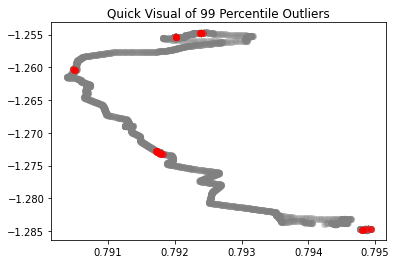

In [57]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.99)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*rads.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*rads[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)
plt.title("Quick Visual of 99 Percentile Outliers")
plt.show()

### Identifying large clusters (clusters with 20 or more data points) ###

In [58]:
large_clusters = pd.Series(cluster_labels).value_counts(sort=True)[pd.Series(cluster_labels).value_counts() > 20].index.tolist()

In [59]:
temp_df['cluster_labels'] = cluster_labels
temp_df['cluster_outliers'] = cluster_outliers 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
large_cluster = []

for i in range(len(temp_df)):
    if temp_df.cluster_labels.iloc[i] in large_clusters:
        large_cluster.append(1)
    else:
        large_cluster.append(0)

temp_df['large_cluster'] = large_cluster        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Directional Change ###

In [61]:
temp1 = temp_df.Direction.diff()

temp1.fillna(0,inplace=True)

directional_change = []

for val in temp1:
    if val >=0:
        directional_change.append(1)
    elif val < 0:
        directional_change.append(-1)


In [62]:
temp_df['directional_change'] = directional_change

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Abrupt Changes ### 

In [63]:
abrupt_dir_changes = temp_df.Direction.diff() / temp_df.time_difference

abrupt_dir_changes.fillna(0,inplace=True)

temp_df['abrupt_directional_change'] = abrupt_dir_changes

np.percentile(abrupt_dir_changes,2.5)
np.percentile(abrupt_dir_changes,97.5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


16.505149041370473

In [64]:
abrupt_changes = []

for x in temp_df['abrupt_directional_change']:
    
    if x < np.percentile(abrupt_dir_changes,2.5):
        abrupt_changes.append(1)
    
    elif x > np.percentile(abrupt_dir_changes,97.5):
        abrupt_changes.append(1)
    
    else:
        abrupt_changes.append(0)

temp_df['abrupt_change_in_direction'] = abrupt_changes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
flags = []

for i in range(len(temp_df)):
    
    if ((temp_df['cluster_labels'].iloc[i] != -1) & (temp_df['large_cluster'].iloc[i] == 1) & (temp_df['abrupt_change_in_direction'].iloc[i] == 1)
       & (temp_df['Average Velocity'].iloc[i] < 0.2) & (temp_df.time_difference.iloc[i] > 120)):
        
        flags.append(1)
    else:
        flags.append(0)

temp_df['Cluster_trip_stops'] = flags

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [66]:
temp_df.drop(['cluster_labels','cluster_outliers','directional_change',
              'abrupt_directional_change','abrupt_change_in_direction'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [67]:
fill_nans = 0

temp_df.fillna(fill_nans,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Section 6: Segmenting Time Series into Trips and Passing through Isolation Forest ###

In [68]:
if 'Study_location_distance' in temp_df.columns:
    stop_list = temp_df[(temp_df['Application_stop'] == 1)|((temp_df['signal_loss_stops'] == 1))
                       |((temp_df['Home_location_distance'] == 1))|((temp_df['Study_location_distance'] == 1))
                       |((temp_df['Work_location_distance'] == 1))|((temp_df['Cluster_trip_stops'] == 1))
                       ].index.tolist()

else:
    stop_list = temp_df[(temp_df['Application_stop'] == 1)|((temp_df['signal_loss_stops'] == 1))
                       |((temp_df['Home_location_distance'] == 1))|((temp_df['Work_location_distance'] == 1))
                        |((temp_df['Cluster_trip_stops'] == 1))
                       ].index.tolist()

# 1. Application_stop 
# 2. signal_loss_stops
# 3. Home_location_distance
# 4. Study_location_distance
# 5. Work_location_distance
# 6. Cluster_trip_stops

In [69]:
stop_agg = []

for x in temp_df.index:
    if x in stop_list:
        stop_agg.append(1)
    else:
        stop_agg.append(0)

temp_df['Trip_ends'] = stop_agg # stops for trips end at 1 values. 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


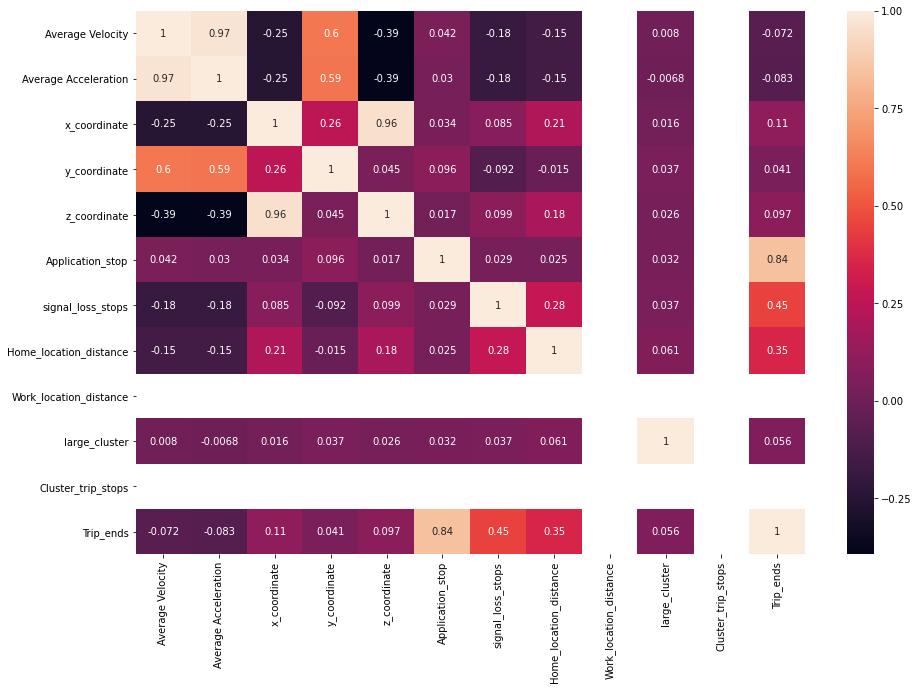

In [70]:
x = temp_df.loc[:,['Average Velocity', 'Average Acceleration','x_coordinate', 'y_coordinate', 'z_coordinate','Application_stop', 'signal_loss_stops', 'Home_location_distance',
'Work_location_distance', 'large_cluster', 'Cluster_trip_stops','Trip_ends']]

from sklearn.preprocessing import StandardScaler
    
scaler = StandardScaler()
scaled_df = scaler.fit_transform(x)
    
y = pd.DataFrame(scaled_df, columns=['Average Velocity', 'Average Acceleration', 'x_coordinate', 'y_coordinate', 'z_coordinate','Application_stop', 'signal_loss_stops', 'Home_location_distance',
'Work_location_distance', 'large_cluster', 'Cluster_trip_stops','Trip_ends'])



plt.figure(figsize=(15,10))

import seaborn as sns
corr = y.corr()
sns.heatmap(corr, xticklabels=y.columns.values, yticklabels=y.columns.values,annot=True)


# Testing Phase 1 - Mixed Validation Set - Optimal Parameter Training #

In [71]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

dftemp1 = pd.read_csv("D:\\Itinerum Data\\validation_set.csv", header=None)

dftemp1.rename({0:'latitude',1:'longitude'},inplace=True,axis=1)

testingset = raw.head(101)
testingset = testingset.iloc[1:101,:]
testing_try1 = (testingset.loc[:,['latitude','longitude']])

lat_test = testing_try1.latitude.append(dftemp1.latitude, ignore_index=True)
long_test = testing_try1.longitude.append(dftemp1.longitude, ignore_index=True)

df = pd.DataFrame()

df['latitude'] = lat_test
df['longitude'] = long_test

normal = []

for i in range(len(testingset)):
    normal.append(1)

outlier = []

for i in range(len(dftemp1.latitude)):
    outlier.append(-1)

labels = pd.Series(normal).append(pd.Series(outlier),ignore_index=True)    
#coords = list(zip(testingset.latitude,testingset.longitude))

df['labels'] = labels

x_coordinate = []
y_coordinate = []
z_coordinate = []

R = 6371000 # radius of earth in meters 

import math 

for i in range(len(df)):
   
    x = R * math.cos(df.latitude.iloc[i]) * math.cos(df.longitude.iloc[i])

    y = R * math.cos(df.latitude.iloc[i]) * math.sin(df.longitude.iloc[i])

    z = R * math.sin(df.latitude.iloc[i])

       
    x_coordinate.append(x)
    y_coordinate.append(y)
    z_coordinate.append(z)

df['x_coordinate'] = x_coordinate
df['y_coordinate'] = y_coordinate
df['z_coordinate'] = z_coordinate

# Model 1: Isolation Forest #

In [72]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification

testing = list(zip(df.x_coordinate,df.y_coordinate,df.z_coordinate))
test_array = np.array(testing)

X_train = test_array
y_train = df.labels

clf = IsolationForest(random_state=0, behaviour='new')

param_grid = {'n_estimators': list(range(100, 500, 100)), 
              'max_samples': list(range(100, 500, 100)), 
              'contamination': [0.1, 0.15, 0.2], 
              'bootstrap': [True, False]} 
              

f1sc = make_scorer(f1_score,average='micro')

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=5, 
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=IsolationForest(behaviour='new', bootstrap=False,
                                       contamination='legacy', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=0, verbose=0,
                                       warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.1, 0.15, 0.2],
                         'max_samples': [100, 200, 300, 400],
                         'n_estimators': [100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(f1_score, average=micro), verbose=0)

### GridSearch Best Parameters ###

In [73]:
grid_dt_estimator.best_params_

{'bootstrap': True,
 'contamination': 0.1,
 'max_samples': 100,
 'n_estimators': 100}

### Classification Results ###

In [74]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

# Grid Search Parameters #

n_estimators = 100
max_samples = 100
contamination = 0.1
bootstrap = True
features_topredict = ['x_coordinate','y_coordinate','z_coordinate']
max_features = len(features_topredict)

clf = IsolationForest(bootstrap=bootstrap, random_state=0, n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, max_features= max_features).fit(df[features_topredict])

testing = list(zip(df.x_coordinate,df.y_coordinate,df.z_coordinate))
test_array = np.array(testing)

prediction = clf.predict(test_array)

# Predictions and True Values #
y_pred = prediction
y_true = df.labels

# Model Performance Metrics #
print("This is the Classification Report:")
print(" ")
print(classification_report(y_true, y_pred))
print("This is the AUC Score:")
print(" ")
print(average_precision_score(y_true, y_pred))
print("This is the pAUC Score:")
print(" ")
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
pAUC = np.trapz(tpr, fpr)
print(pAUC)

This is the Classification Report:
 
              precision    recall  f1-score   support

          -1       0.91      1.00      0.95        10
           1       1.00      0.99      0.99       100

    accuracy                           0.99       110
   macro avg       0.95      0.99      0.97       110
weighted avg       0.99      0.99      0.99       110

This is the AUC Score:
 
0.9990909090909091
This is the pAUC Score:
 
0.995


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


# Model 2 - Cluster-based Local Outlier Factor # 

In [75]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

testing = list(zip(df.x_coordinate,df.y_coordinate,df.z_coordinate))
test_array = np.array(testing)

X_train = test_array
y_train = df.labels


lof = LocalOutlierFactor()

param_grid = {'n_neighbors': list(range(5,20,5)), 
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
              'contamination': [0.1, 0.15, 0.2], 
              'metric': ['minkowski', 'euclidean', 'l1', 'l2', 'manhattan'],
             'novelty':[True]} 
              

f1sc = make_scorer(f1_score,average='micro')

grid_dt_estimator = model_selection.GridSearchCV(lof, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=5, 
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)







GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LocalOutlierFactor(algorithm='auto',
                                          contamination='legacy', leaf_size=30,
                                          metric='minkowski',
                                          metric_params=None, n_jobs=None,
                                          n_neighbors=20, novelty=False, p=2),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'contamination': [0.1, 0.15, 0.2],
                         'metric': ['minkowski', 'euclidean', 'l1', 'l2',
                                    'manhattan'],
                         'n_neighbors': [5, 10, 15], 'novelty': [True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(f1_score, average=micro), verbose=0)

### GridSearch Best Parameters ###

In [76]:
grid_dt_estimator.best_params_

{'algorithm': 'auto',
 'contamination': 0.1,
 'metric': 'minkowski',
 'n_neighbors': 10,
 'novelty': True}

In [77]:
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn import metrics

# Grid Search Parameters #

n_neighbors = 5
metric = 'minkowski'
contamination = 0.1
novelty = True
algorithm = 'auto'

features_topredict = ['x_coordinate','y_coordinate','z_coordinate']
max_features = len(features_topredict)

lof = LocalOutlierFactor(n_neighbors = n_neighbors, metric=metric, novelty=novelty, algorithm=algorithm, contamination=contamination).fit(df[features_topredict])

testing = list(zip(df.x_coordinate,df.y_coordinate,df.z_coordinate))
test_array = np.array(testing)

prediction = lof.predict(test_array)

# Predictions and True Values #
y_pred = prediction
y_true = df.labels

# Model Performance Metrics #

print("This is the Classification Report:")
print(" ")
print(classification_report(y_true, y_pred))
print("This is the AUC Score:")
print(" ")
print(average_precision_score(y_true, y_pred))
print("This is the pAUC Score:")
print(" ")
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
pAUC = np.trapz(tpr, fpr)
print(pAUC)

This is the Classification Report:
 
              precision    recall  f1-score   support

          -1       0.88      0.70      0.78        10
           1       0.97      0.99      0.98       100

    accuracy                           0.96       110
   macro avg       0.92      0.84      0.88       110
weighted avg       0.96      0.96      0.96       110

This is the AUC Score:
 
0.9699732620320856
This is the pAUC Score:
 
0.845


# Model 3 - One Class Support Vector Machines # 

In [78]:
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.svm import OneClassSVM

testing = list(zip(df.x_coordinate,df.y_coordinate,df.z_coordinate))
test_array = np.array(testing)

X_train = test_array
y_train = df.labels


ocsvm = OneClassSVM()


param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'degree': [2,3,4,5], 
              'gamma': ['scale','auto'], 
              'nu': [0.25, 0.5, 0.75, 1],
             'shrinking':[True,False]} 
              

f1sc = make_scorer(f1_score,average='micro')

grid_dt_estimator = model_selection.GridSearchCV(ocsvm, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=5, 
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='auto_deprecated', kernel='rbf',
                                   max_iter=-1, nu=0.5, random_state=None,
                                   shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.25, 0.5, 0.75, 1],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(f1_score, average=micro), verbose=0)

### GridSearch Best Parameters ###

In [79]:
grid_dt_estimator.best_params_

{'degree': 2,
 'gamma': 'scale',
 'kernel': 'linear',
 'nu': 0.25,
 'shrinking': True}

### Classification Results ###

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn import metrics

degree = 2
gamma = 'scale'
kernel = 'linear'
nu = 0.25
shrinking = True
    
features_topredict = ['x_coordinate','y_coordinate','z_coordinate']
max_features = len(features_topredict)

ocsvm = OneClassSVM(degree=degree,gamma=gamma,kernel=kernel, nu=nu, shrinking=shrinking).fit(df[features_topredict])

testing = list(zip(df.x_coordinate,df.y_coordinate,df.z_coordinate))
test_array = np.array(testing)

prediction = ocsvm.predict(test_array)

prediction
# predictions.append(prediction)

from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification

y_pred = prediction
y_true = df.labels

print("This is the Classification Report:")
print(" ")
print(classification_report(y_true, y_pred))
print("This is the AUC Score:")
print(" ")
print(average_precision_score(y_true, y_pred))
print("This is the pAUC Score:")
print(" ")
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
pAUC = np.trapz(tpr, fpr)
print(pAUC)

This is the Classification Report:
 
              precision    recall  f1-score   support

          -1       0.36      1.00      0.53        10
           1       1.00      0.82      0.90       100

    accuracy                           0.84       110
   macro avg       0.68      0.91      0.71       110
weighted avg       0.94      0.84      0.87       110

This is the AUC Score:
 
0.9836363636363636
This is the pAUC Score:
 
0.9099999999999999


### Part 7: Feeding in Trip Segments into Isolation Forest ###

In [95]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.ensemble import IsolationForest

outliers = [] # Contain the outlier data indexes can be analyzed later to clean from dataset # 
predictions = [] # Contains all the prediction scores from the Isolation Forest #

trip_length = 5

import pprint
stop = len(stop_list)

for i in range(0,25):
    try:
        if (i == 0):
            isolation_df = temp_df.loc[:stop_list[i]]
            
            if len(isolation_df) < trip_length:                             # Ensures only analyzing trips of size greater than 5
                continue
        
        else: 
            isolation_df = temp_df.loc[(stop_list[i-1]+1):stop_list[i]]
            
            if len(isolation_df) < trip_length:                             
                continue
    
    except IndexError as e:                                                 # Ensures only analyzing trips of size greater than 5
        pass
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    isolation_numeric = isolation_df.select_dtypes(include=numerics)
    
     # Standard Scaler #
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(isolation_numeric)
    
    isolation_numeric = pd.DataFrame(scaled_df, columns=['latitude', 'longitude', 'instantaneous_speed', 'time_difference',
       'insta_speed_difference', 'instantaneous_acceleration',
       'insta_acceleration_difference', 'instantaneous_jerk', 'ClosedTransit',
       'Distance', 'Direction', 'Average Velocity', 'Average Acceleration',
       'Weekends', 'x_coordinate', 'y_coordinate', 'z_coordinate',
       'Application_stop', 'signal_loss_stops', 'Home_location_distance',
       'Work_location_distance', 'large_cluster', 'Cluster_trip_stops',
       'Trip_ends'])
    
            
     # Isolation Forest Parameters - derived from GridSearch #
    n_estimators = 100
    max_samples = 100
    contamination = 0.1
    bootstrap = True
    
    features_topredict = ['x_coordinate','y_coordinate','z_coordinate','Average Velocity','Average Acceleration']
    max_features = len(features_topredict)

    
    
    clf = IsolationForest(bootstrap = True, random_state=0, n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, max_features= max_features).fit(isolation_numeric[features_topredict])
    
     # Specify feature columns names below: 
    
    testing = list(zip(isolation_numeric.x_coordinate,isolation_numeric.y_coordinate,isolation_numeric.z_coordinate,
                       isolation_numeric['Average Velocity'],isolation_numeric['Average Acceleration']))
    
    
    test_array = np.array(testing)
    
    
    prediction = clf.predict(test_array)
    
    predictions.append(prediction)
    
    isolation_numeric['anomaly']= prediction
    
    outlier = isolation_numeric.loc[isolation_numeric['anomaly']==-1]
       
    outliers.append(outlier.index)
    
   

### Viewing Scaled version of Last Trip ###

In [96]:
isolation_numeric

,latitude,longitude,instantaneous_speed,time_difference,insta_speed_difference,instantaneous_acceleration,insta_acceleration_difference,instantaneous_jerk,ClosedTransit,Distance,...,y_coordinate,z_coordinate,Application_stop,signal_loss_stops,Home_location_distance,Work_location_distance,large_cluster,Cluster_trip_stops,Trip_ends,anomaly
0,-1.829989,-1.246640,-1.573308,0.400653,-0.843922,-0.732703,-0.364145,-0.078532,0.0,-0.455222,...,-0.377020,-1.831105,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
1,-1.636740,-1.208989,-0.752431,-0.106197,1.089031,0.936556,1.085137,0.598942,0.0,-0.237261,...,-0.238938,-1.637369,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
2,-1.749116,-1.291406,-0.568152,0.231703,0.263725,0.077247,-0.560418,-0.170556,0.0,-0.416943,...,-0.255607,-1.750021,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
3,-1.890075,-1.258350,0.369993,0.569603,1.241061,0.687172,0.395737,0.186671,0.0,-0.526056,...,-0.419943,-1.891356,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
4,-1.720210,-1.231520,0.101952,0.231703,-0.322676,-0.384471,-0.698602,-0.226020,0.0,-0.387183,...,-0.291993,-1.721042,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
5,-1.253164,-1.241452,-1.154493,0.738553,-1.604072,-1.097437,-0.465181,-0.089352,0.0,1.240583,...,0.147825,-1.253020,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
6,-1.007949,-1.278065,-0.316863,-0.781998,1.110750,2.026725,2.031967,2.094071,0.0,0.040206,...,0.411711,-1.007445,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,-1
7,-0.782221,-1.216697,-0.316863,0.062753,0.024821,-0.110860,-1.392301,-0.566496,0.0,0.001718,...,0.554815,-0.781479,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
8,-0.651981,-1.148509,0.202467,-0.444097,0.698097,0.772675,0.573799,0.438554,0.0,-0.429216,...,0.603012,-0.651142,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1
9,-0.461005,-1.107152,1.073602,0.231703,1.154187,0.778375,0.002517,0.055394,0.0,-0.239747,...,0.735244,-0.460078,0.0,-0.171499,0.0,0.0,0.544331,0.0,-0.171499,1


In [97]:
outliers

[Int64Index([0, 3, 5, 6, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41], dtype='int64'),
 Int64Index([38, 40, 42, 43, 44], dtype='int64'),
 Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
              13,  14,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             456, 457, 458, 463, 464, 467, 468, 469, 470, 471, 472, 473, 474,
             475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 489, 651, 692,
             693, 737, 740, 741, 743, 773, 774, 775, 776, 777, 778, 779, 780,
             781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
             794, 795],
            dtype='int64'),
 Int64Index([0, 6, 7, 8, 78, 79, 80, 81, 82], dtype='int64'),
 Int64Index([0, 1, 34, 36], dtype='int64'),
 Int64Index([0, 1, 2, 4, 5, 68, 69, 99, 100, 140, 143, 144, 145, 146, 147], dtype='int64'),
 Int64Index([0, 1, 2, 5, 6, 10, 14, 15, 16, 17], dtype='int64'),
 Int64Index([0, 14], dtype='int64'),
 Int64Index([0, 5], dtype='int64'),
 Int64In

### 3D Visual of Inliers and Outliers of Last trip for User ID ###

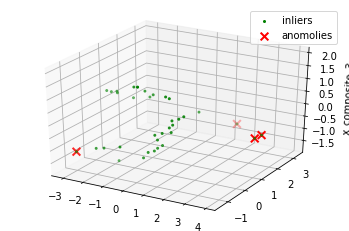

In [98]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

isolation_numeric = (isolation_numeric.reset_index(drop=True))
outliers = isolation_numeric.loc[isolation_numeric['anomaly']==-1]
outlier_index=list(outliers.index)

#print(isolation_numeric.head())
#print(outlier_index)

pca = PCA(n_components=3)  # Reduce to k=3 dimensions


to_model_columns = ['x_coordinate', 'y_coordinate', 'z_coordinate','Average Velocity','Average Acceleration']

#normalize the metrics
X = scaler.fit_transform(isolation_numeric.loc[:, to_model_columns])
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")


# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")


# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="anomolies")

ax.legend()
plt.show()

### Folium Visualization 1st Confirmation ###

In [130]:
import os
import folium
from folium import plugins

coords = list(zip(isolation_df.latitude,isolation_df.longitude))
print(len(isolation_df))
map_1 = folium.Map(location=[45.5017, -73.5673], zoom_start=7)

for lat,lon in coords:
    folium.CircleMarker([lat,lon], radius = 2, color = 'red').add_to(map_1)     
    
plugins.MarkerCluster(coords).add_to(map_1)
map_1

28


### Assessing trip purity through Approximate Entropy - Smaller Values indicate more orderly trips ###

In [112]:
X_entropy = []
Y_entropy = []
Z_entropy = []

from entropy import *

for i in range(0,len(stop_list)):
    try:
        if i == 0:
            isolation_df = temp_df.loc[:stop_list[i]]
           
            if len(isolation_df) < trip_length:                             # Ensures only analyzing trips of size greater than 5
                continue
        
        else: 
            isolation_df = temp_df.loc[(stop_list[i-1]+1):stop_list[i]]
            
            if len(isolation_df) < trip_length:                             
                continue
    
    except IndexError as e:                                                 # Ensures only analyzing trips of size greater than 5
        pass
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    isolation_numeric = isolation_df.select_dtypes(include=numerics)
    
    X_entropy.append(app_entropy(isolation_numeric.x_coordinate.values, order=2, metric='chebyshev'))
    Y_entropy.append(app_entropy(isolation_numeric.y_coordinate.values, order=2, metric='chebyshev'))
    Z_entropy.append(app_entropy(isolation_numeric.z_coordinate.values, order=2, metric='chebyshev'))
    

In [113]:
print(np.asarray(X_entropy).mean())
print(np.asarray(Y_entropy).mean())
print(np.asarray(Z_entropy).mean())

-0.05746756350049026
-0.0686569210467001
-0.060223969644884176
